In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

data_dir = r"D:\Project_16__Style_transfer\D3_Zeiss_large"
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
print(len(dataloader))

27


In [18]:
import matplotlib.pyplot as plt


# for batch_count,(images, labels) in enumerate(dataloader):
#     if batch_count>=4:
#         break
#     plt.figure(figsize=(20,5))
#     plt.suptitle(f'Batch {batch_count+1}')
#     for i,(image,label) in enumerate(zip(images,labels)):
#         if i==4:
#             break
#         plt.subplot(1,4,i+1)
#         plt.imshow(image.squeeze(0),cmap='grey')
#         plt.axis('off')
#     plt.show()

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.init_size = 4  # Initial feature map size
        
        # Project latent vector to initial feature map
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size**2),
            nn.BatchNorm1d(128 * self.init_size**2),
            nn.ReLU()
        )
        
        self.model = nn.Sequential(
            nn.Unflatten(1, (128, self.init_size, self.init_size)),
            
            # Block 1: 4x4 -> 8x8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 2: 8x8 -> 16x16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Block 3: 16x16 -> 32x32
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Block 4: 32x32 -> 64x64
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            # Block 5: 64x64 -> 128x128
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            
            # Final output layer
            nn.Conv2d(4, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        out = self.l1(z)*0.5
        img = self.model(out)
        return img


In [20]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1),  # Global feature map
            nn.Flatten(),
            nn.Linear(256, 1),  # Single output

        )

    def forward(self, img):
        return self.model(img)


In [21]:
def model_size(model):
    # Calculate the number of parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Each parameter is a 32-bit (4-byte) float
    total_size_bytes = total_params * 4  # Size in bytes

    # Convert bytes to MB
    total_size_MB = total_size_bytes / (1024 ** 2)

    print(f'Total number of parameters: {total_params}')
    print(f'Model size: {total_size_MB:.2f} MB')
def normalize(x):
    x -= x.min()
    x /= x.max()
    return x

In [22]:
G = Generator().to(device)
D = Discriminator().to(device)
model_size(G)
model_size(D)

Total number of parameters: 443289
Model size: 1.69 MB
Total number of parameters: 393569
Model size: 1.50 MB


In [23]:
adversarial_loss = nn.BCEWithLogitsLoss()
os.makedirs("saved_models", exist_ok=True)
os.makedirs("saved_images", exist_ok=True)

In [24]:
def plot_history(y1 , y2):
    plt.figure(figsize=(6, 3))
    plt.plot(y1, label="Discriminator Loss", color="red", linewidth=2, linestyle="-")
    plt.plot(y2, label="Generator Loss", color="green", linewidth=2, linestyle="--")

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.title("Loss", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

In [25]:
# G.load_state_dict(torch.load("saved_models/generator_G.pth", weights_only=True))
# D.load_state_dict(torch.load("saved_models/discriminator_D.pth", weights_only=True))


In [26]:
loss_G_history = []
loss_D_history = []

In [27]:
num_epochs = 2500
optimizer_G = optim.Adam(G.parameters(), lr=0.0003)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

  2%|▏         | 49/2500 [1:05:40<54:32:50, 80.12s/it]

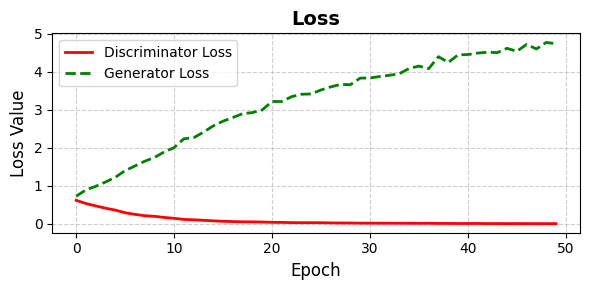

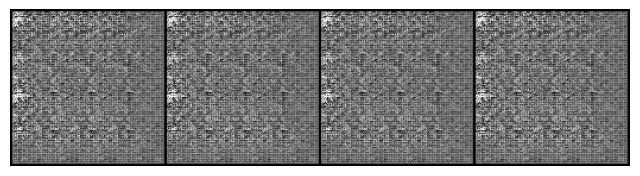

  4%|▍         | 99/2500 [2:11:49<53:04:45, 79.59s/it]

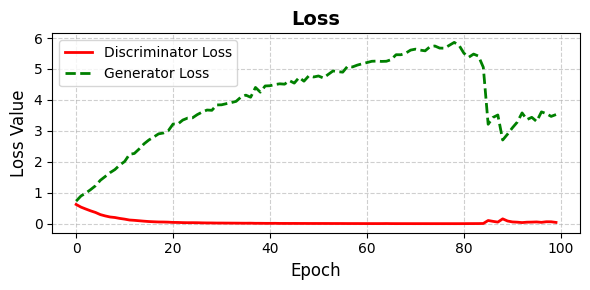

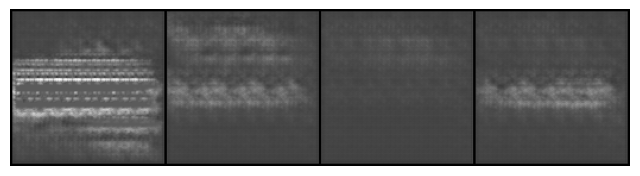

  6%|▌         | 149/2500 [3:18:07<52:11:07, 79.91s/it]

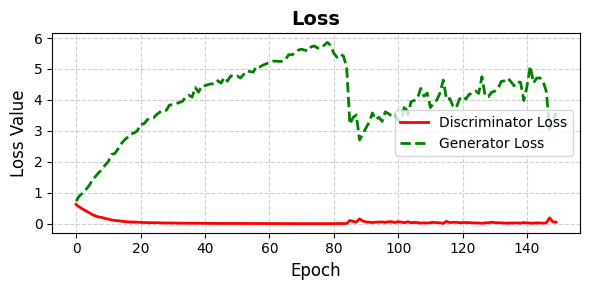

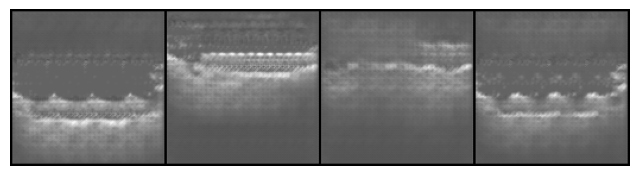

  8%|▊         | 199/2500 [4:24:20<50:39:36, 79.26s/it]

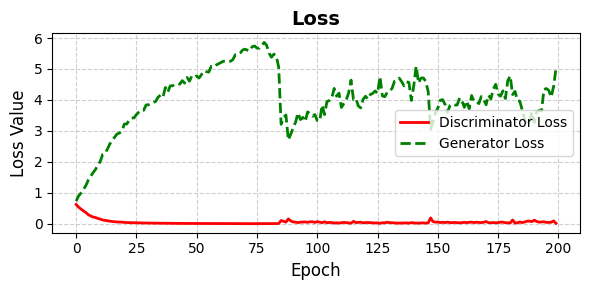

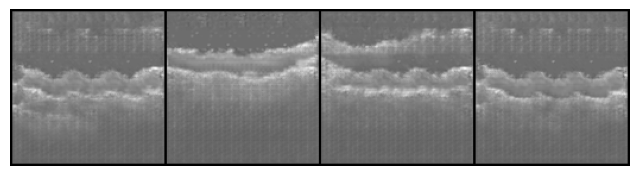

 10%|▉         | 249/2500 [5:30:16<49:14:27, 78.75s/it]

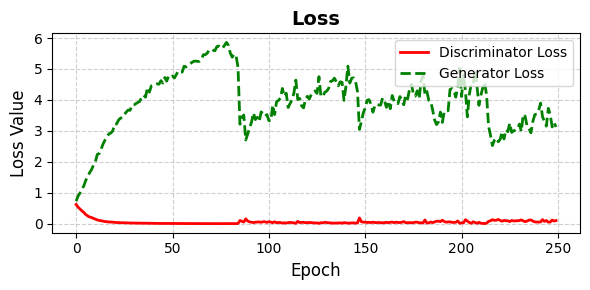

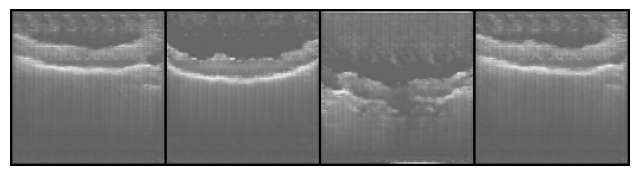

 12%|█▏        | 299/2500 [6:37:20<49:57:19, 81.71s/it]

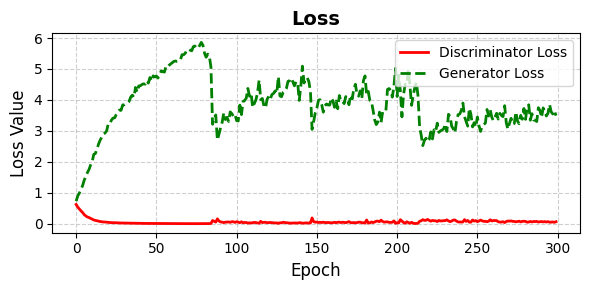

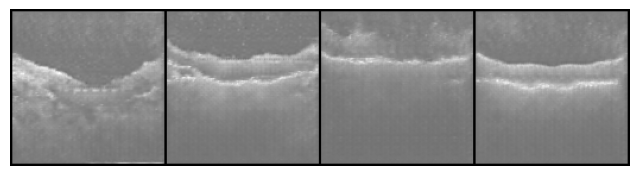

 14%|█▍        | 349/2500 [7:42:50<46:49:51, 78.38s/it]

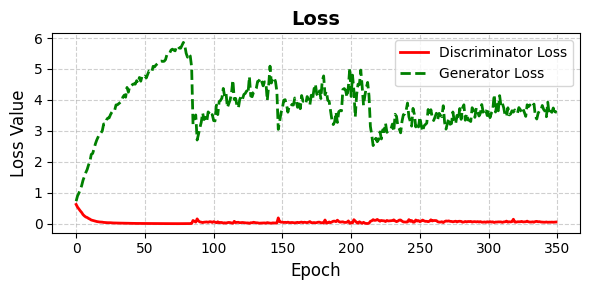

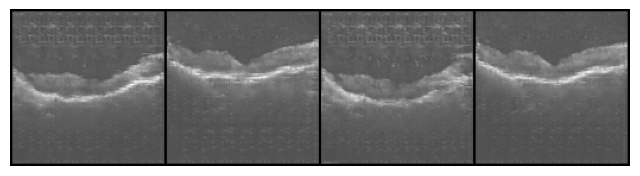

 16%|█▌        | 399/2500 [8:50:15<45:37:00, 78.16s/it] 

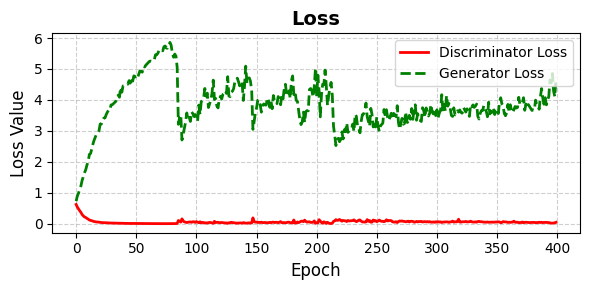

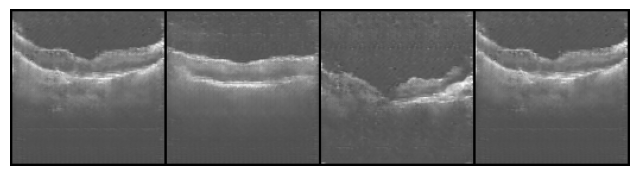

 18%|█▊        | 449/2500 [9:58:13<45:12:52, 79.36s/it] 

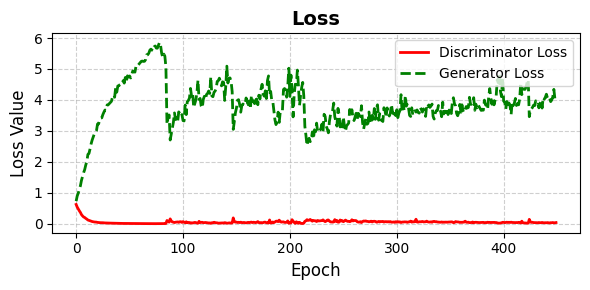

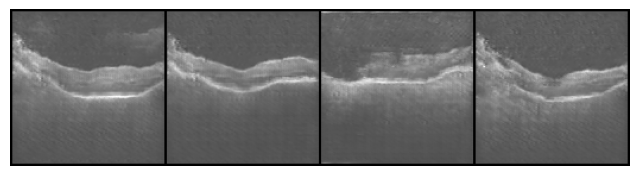

 20%|█▉        | 499/2500 [11:04:00<43:51:41, 78.91s/it]

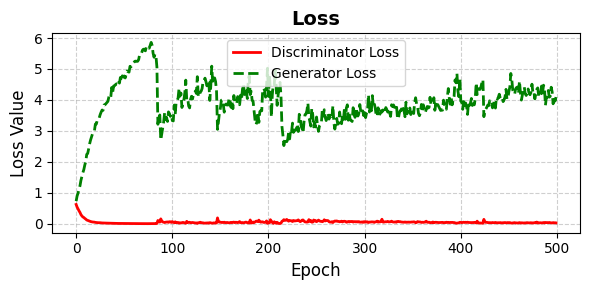

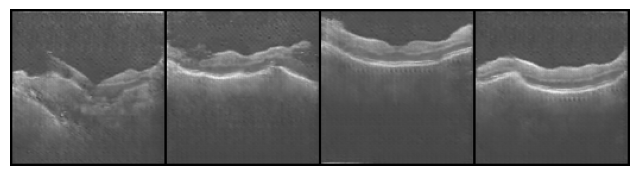

 22%|██▏       | 549/2500 [12:09:56<42:17:34, 78.04s/it]

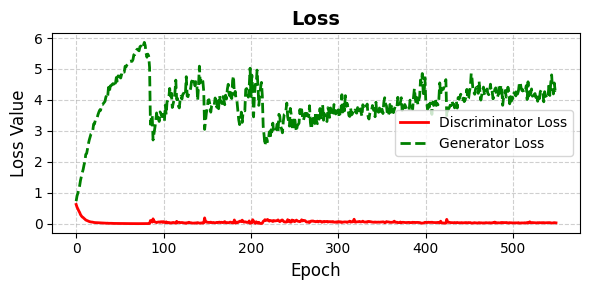

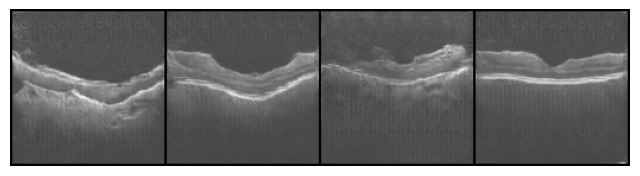

 24%|██▍       | 599/2500 [13:15:42<41:34:01, 78.72s/it]

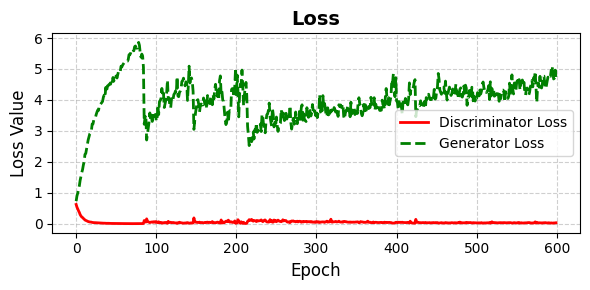

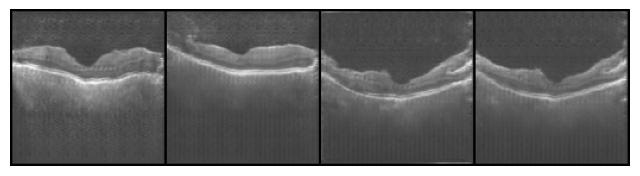

 26%|██▌       | 649/2500 [14:21:26<40:32:04, 78.84s/it]

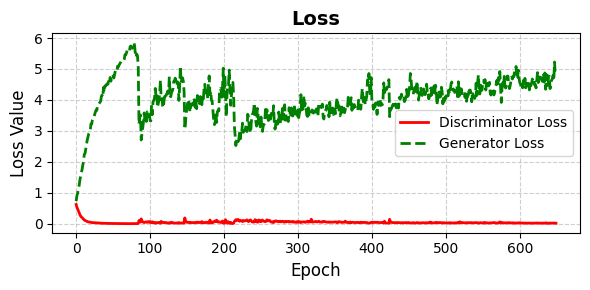

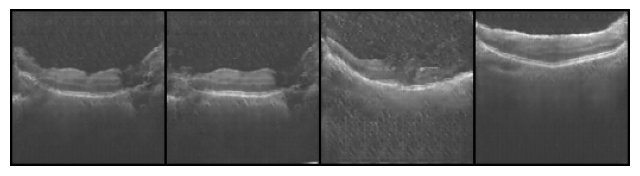

 28%|██▊       | 699/2500 [15:27:48<39:36:18, 79.17s/it]

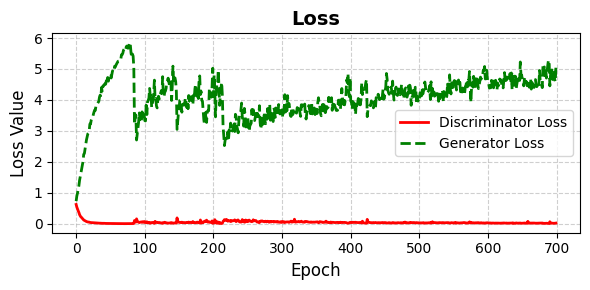

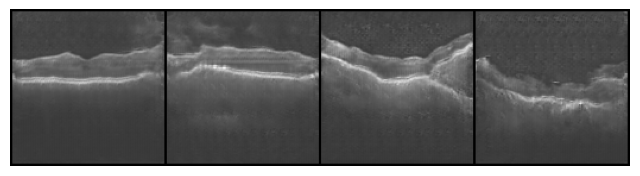

 30%|██▉       | 749/2500 [16:33:15<38:13:29, 78.59s/it]

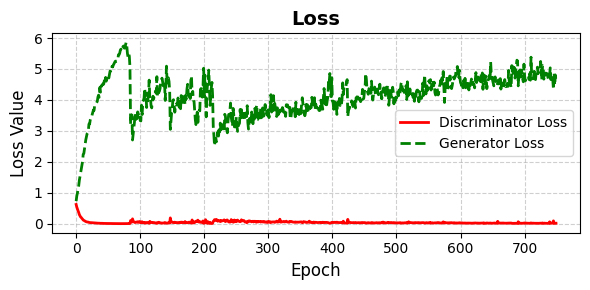

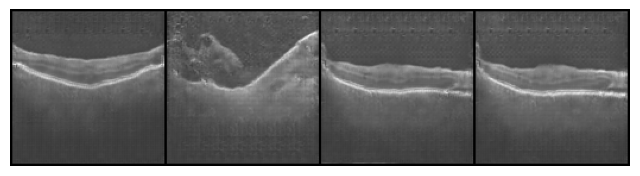

 32%|███▏      | 799/2500 [17:38:34<37:14:54, 78.83s/it]

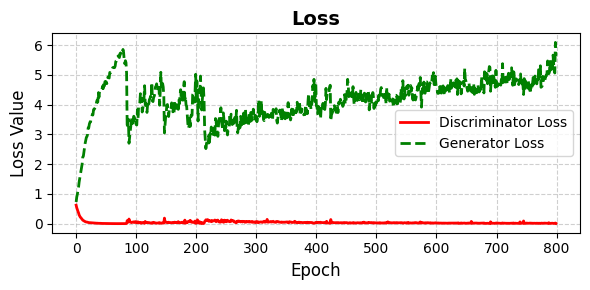

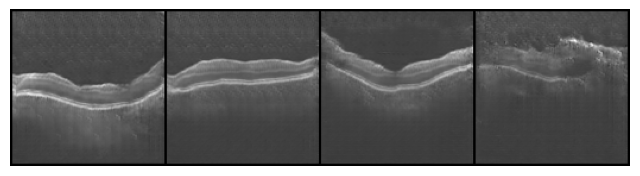

 34%|███▍      | 849/2500 [18:43:34<35:59:56, 78.50s/it]

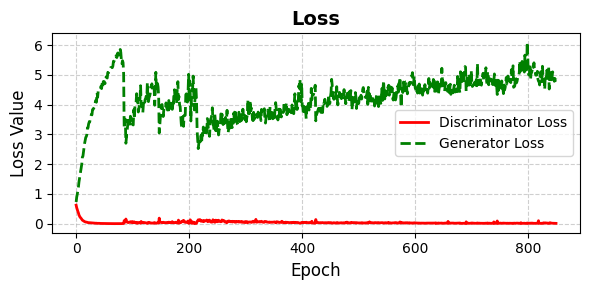

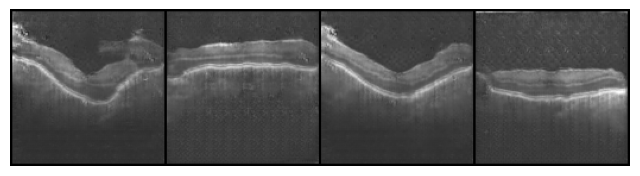

 36%|███▌      | 899/2500 [19:50:37<35:25:41, 79.66s/it]

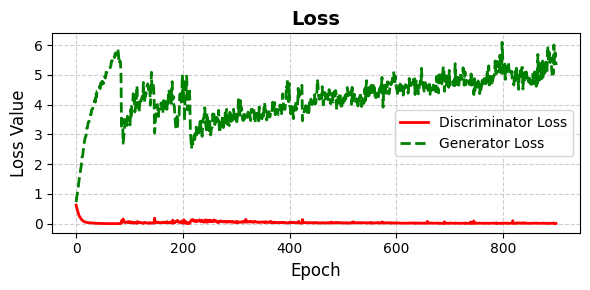

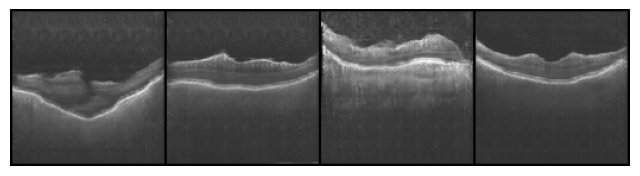

 38%|███▊      | 949/2500 [20:56:08<33:55:22, 78.74s/it]

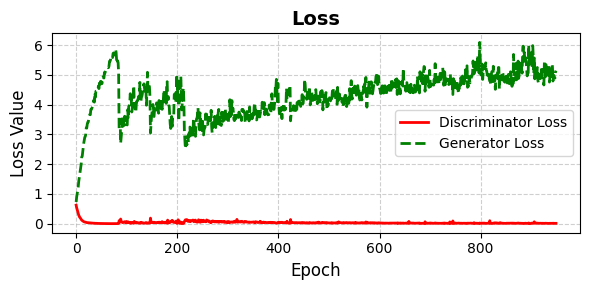

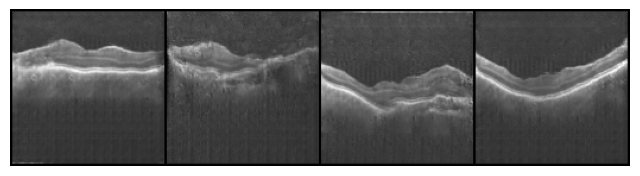

 40%|███▉      | 999/2500 [22:02:41<32:52:08, 78.83s/it]

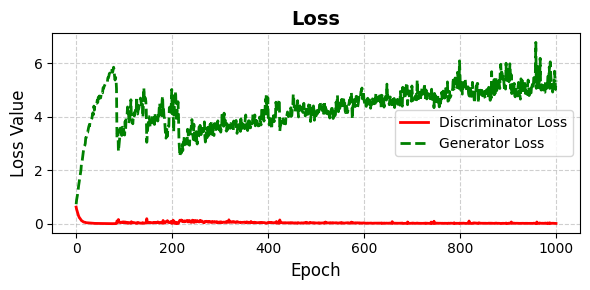

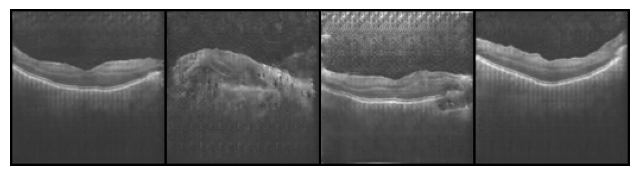

 42%|████▏     | 1049/2500 [23:08:28<31:46:14, 78.82s/it]

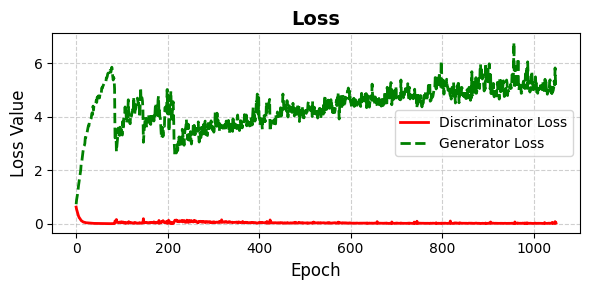

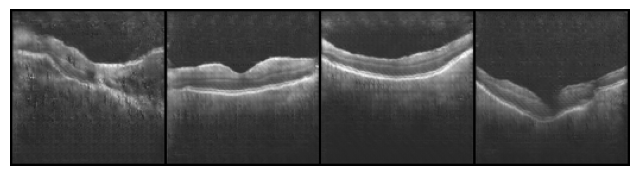

 44%|████▍     | 1099/2500 [24:14:31<30:48:21, 79.16s/it]

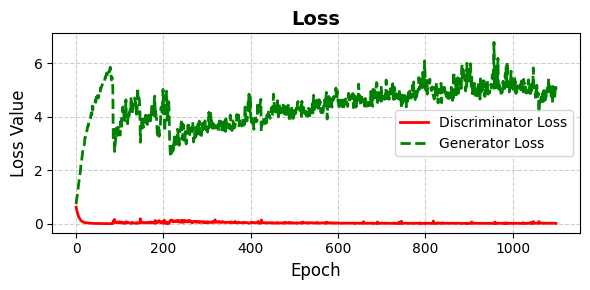

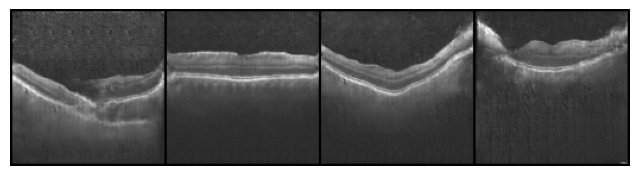

 46%|████▌     | 1149/2500 [25:20:31<29:37:42, 78.95s/it]

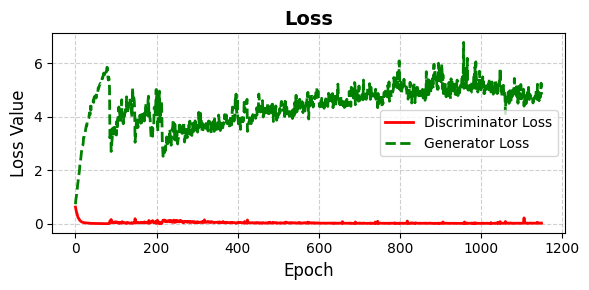

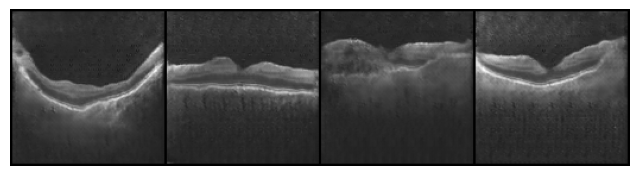

 48%|████▊     | 1199/2500 [26:26:35<28:46:54, 79.64s/it]

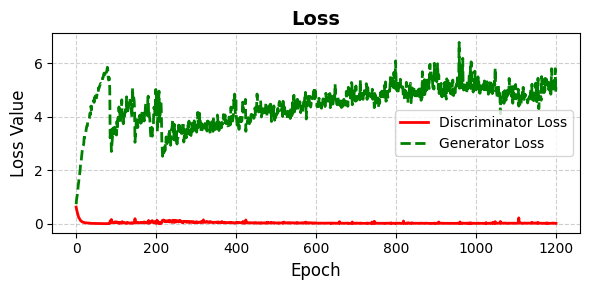

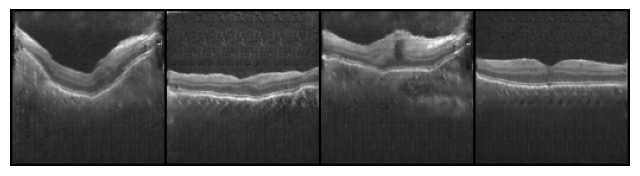

 50%|████▉     | 1249/2500 [27:32:51<27:23:36, 78.83s/it]

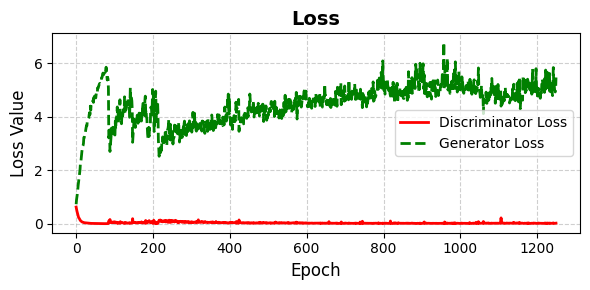

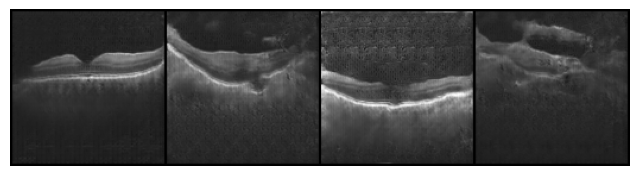

 52%|█████▏    | 1299/2500 [28:39:14<26:28:05, 79.34s/it]

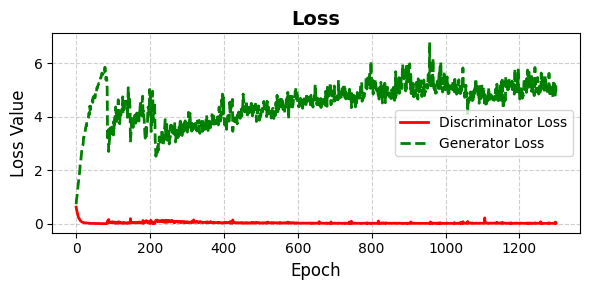

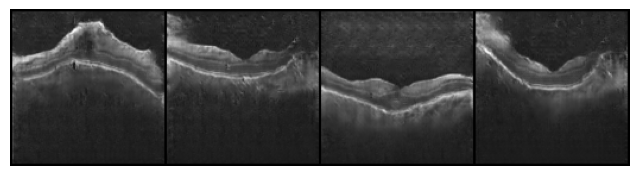

 54%|█████▍    | 1349/2500 [29:45:25<25:12:58, 78.87s/it]

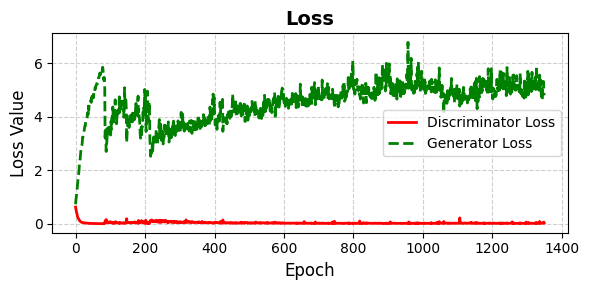

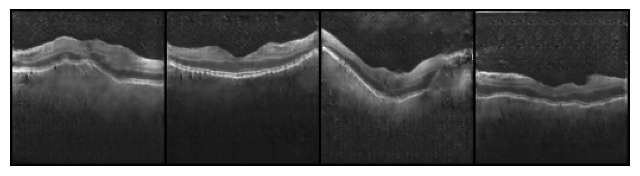

 56%|█████▌    | 1399/2500 [30:51:31<24:12:11, 79.14s/it]

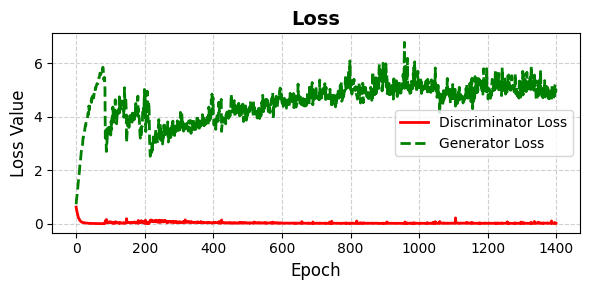

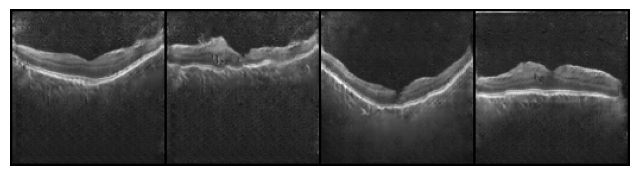

 58%|█████▊    | 1449/2500 [31:58:20<23:36:35, 80.87s/it]

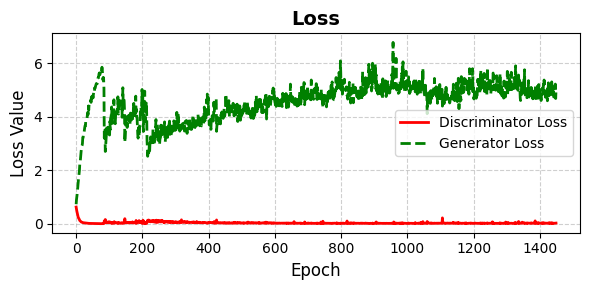

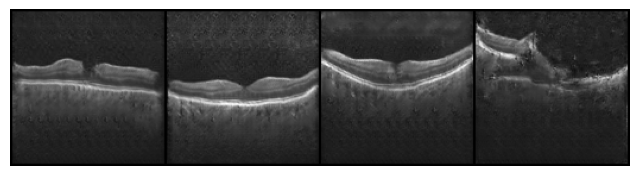

 60%|█████▉    | 1499/2500 [33:05:15<22:17:20, 80.16s/it]

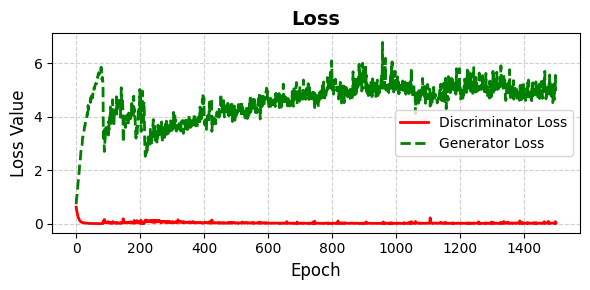

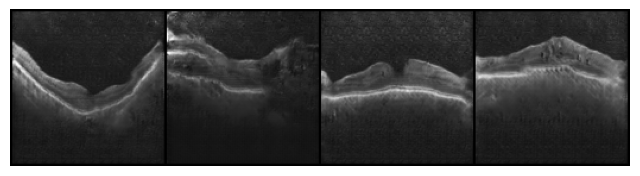

 62%|██████▏   | 1549/2500 [34:15:27<21:09:41, 80.11s/it] 

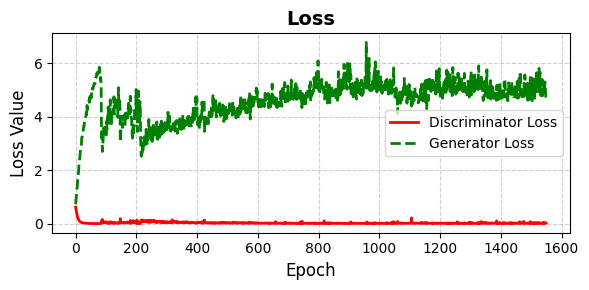

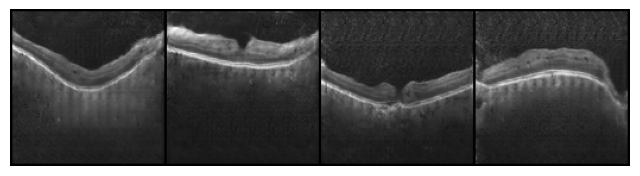

 64%|██████▍   | 1599/2500 [35:22:03<19:38:58, 78.51s/it]

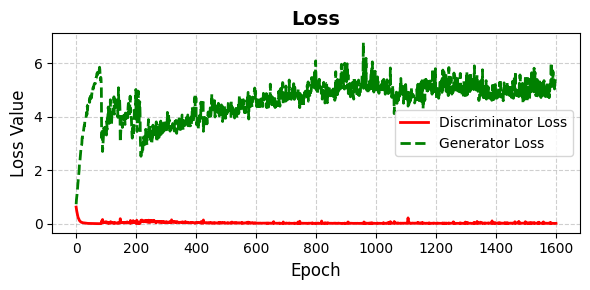

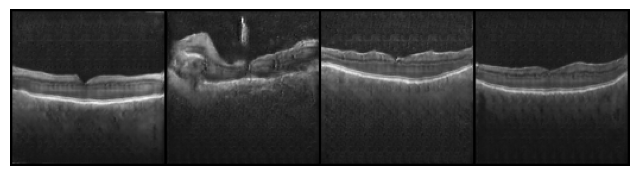

 66%|██████▌   | 1649/2500 [36:27:37<18:37:07, 78.76s/it]

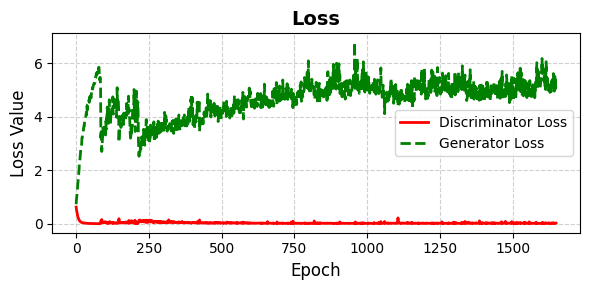

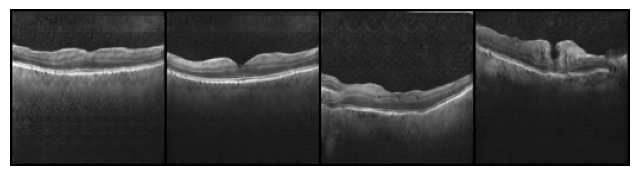

 68%|██████▊   | 1699/2500 [37:33:10<17:25:25, 78.31s/it]

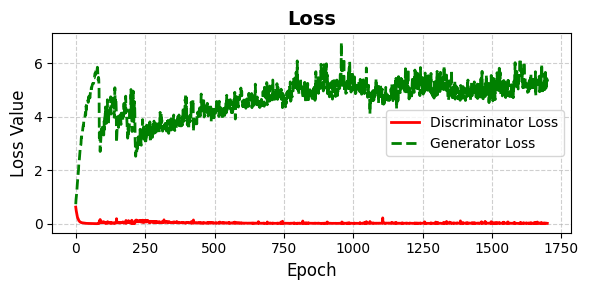

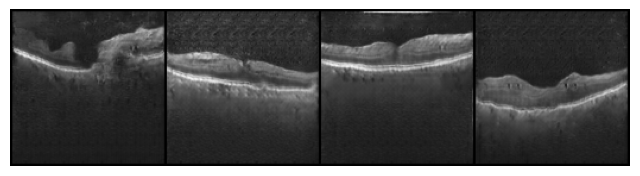

 70%|██████▉   | 1749/2500 [38:38:41<16:18:25, 78.17s/it]

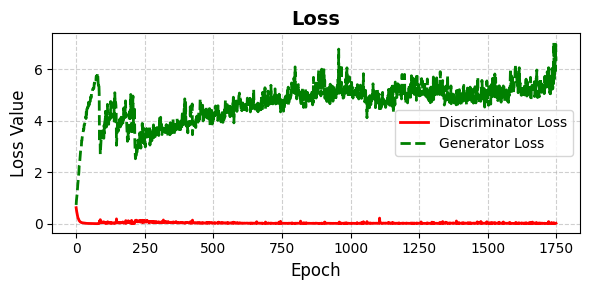

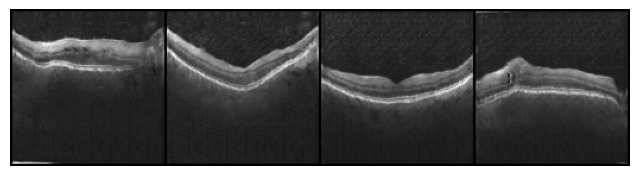

 72%|███████▏  | 1799/2500 [39:43:58<15:15:05, 78.32s/it]

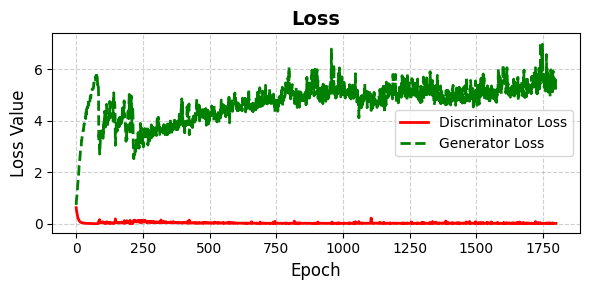

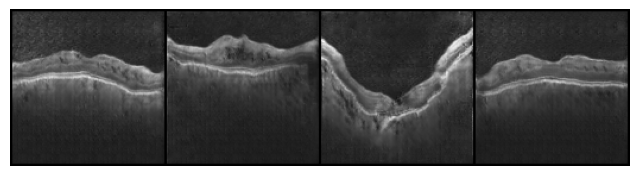

 74%|███████▍  | 1849/2500 [40:49:11<14:12:09, 78.54s/it]

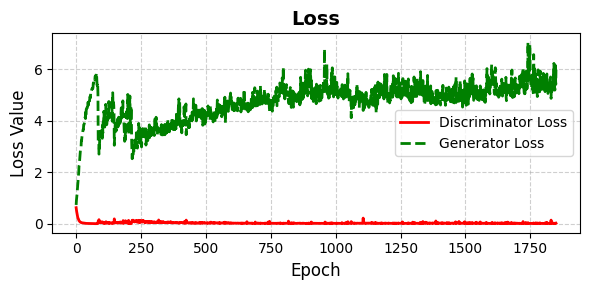

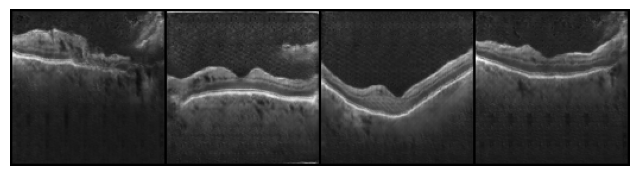

 76%|███████▌  | 1899/2500 [41:54:36<13:08:14, 78.69s/it]

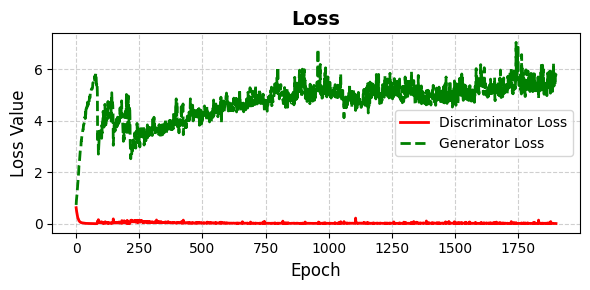

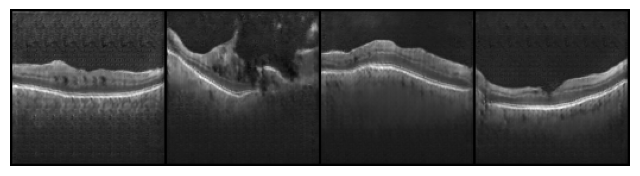

 78%|███████▊  | 1949/2500 [42:59:52<12:02:40, 78.69s/it]

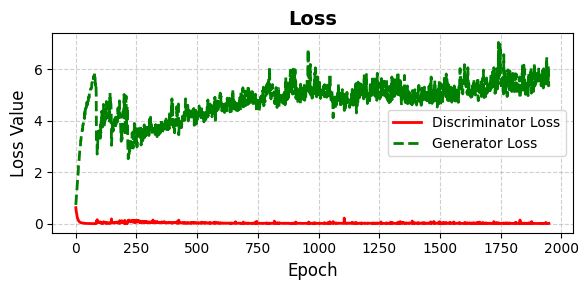

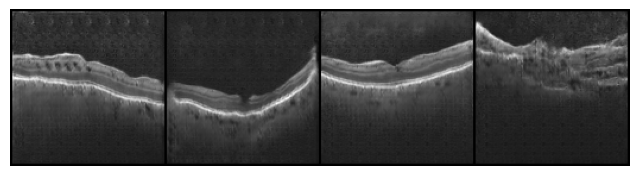

 80%|███████▉  | 1999/2500 [44:06:37<11:05:31, 79.70s/it]

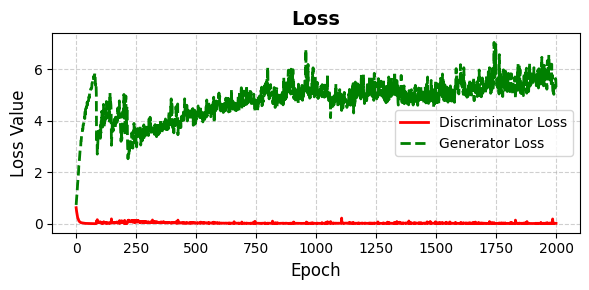

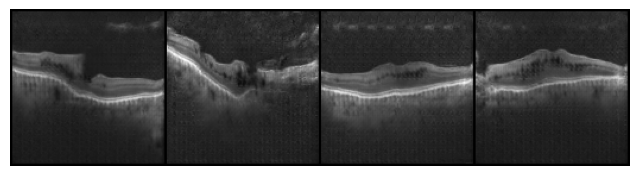

 82%|████████▏ | 2049/2500 [45:12:21<9:54:24, 79.08s/it] 

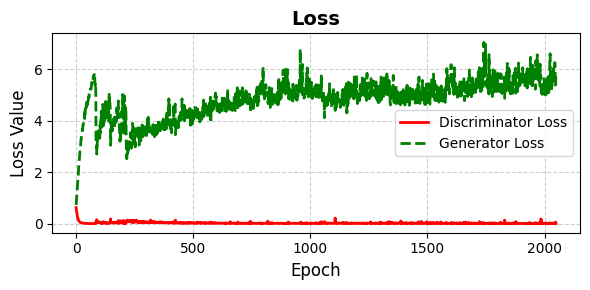

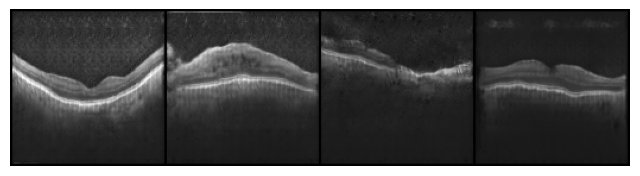

 84%|████████▍ | 2099/2500 [46:19:30<9:00:58, 80.94s/it] 

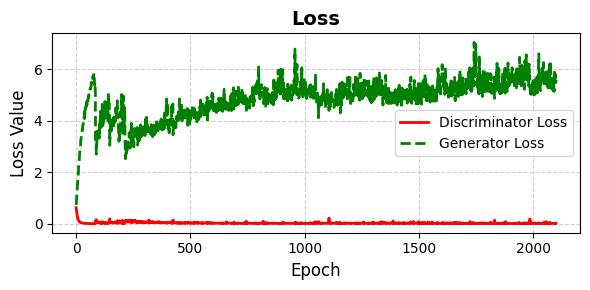

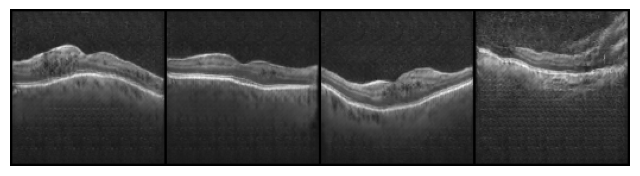

 86%|████████▌ | 2149/2500 [47:25:43<7:45:45, 79.62s/it]

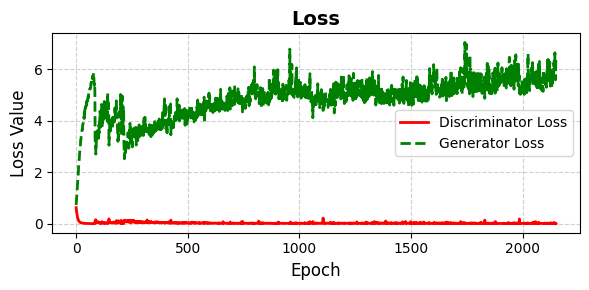

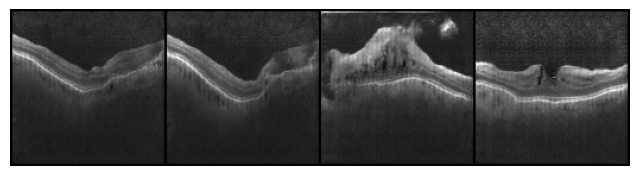

 88%|████████▊ | 2199/2500 [48:32:09<6:39:43, 79.68s/it]

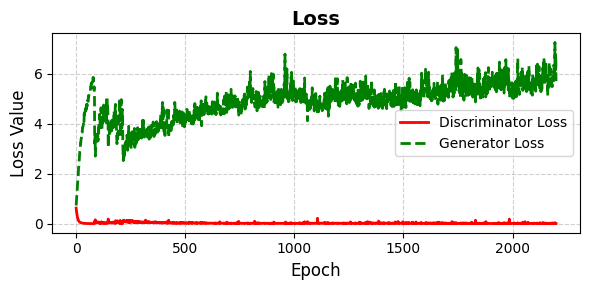

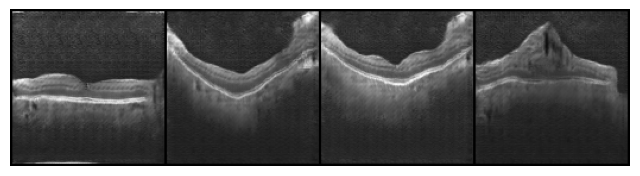

 90%|████████▉ | 2249/2500 [49:38:32<5:33:46, 79.79s/it]

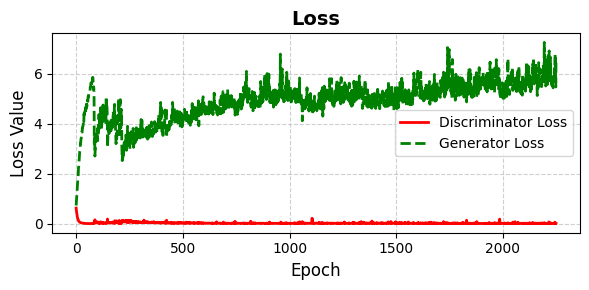

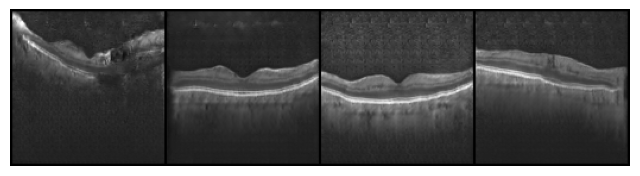

 92%|█████████▏| 2299/2500 [51:12:00<8:52:25, 158.94s/it]

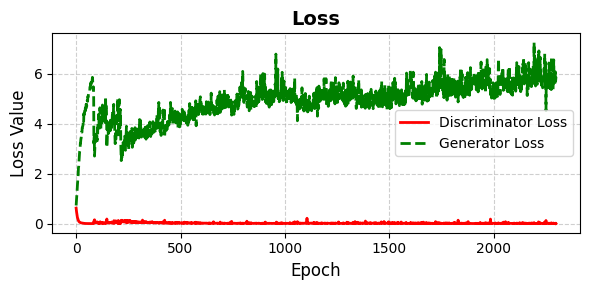

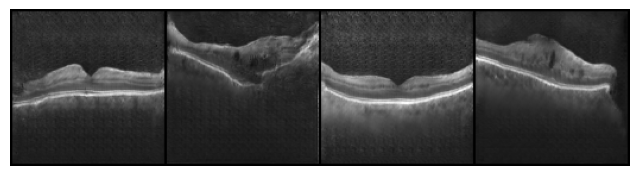

 94%|█████████▍| 2349/2500 [54:16:35<3:38:50, 86.95s/it]  

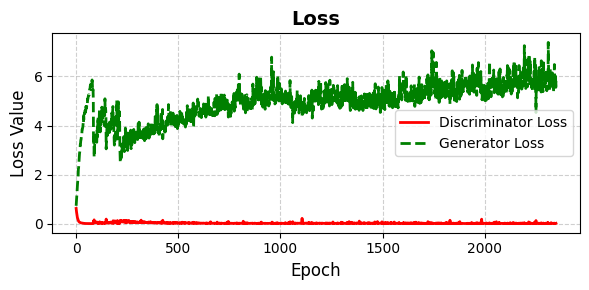

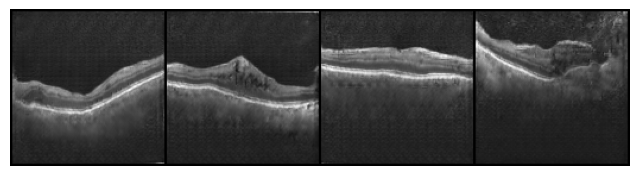

 96%|█████████▌| 2399/2500 [55:22:42<2:13:32, 79.34s/it]

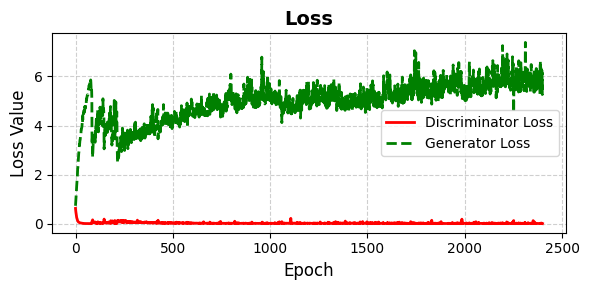

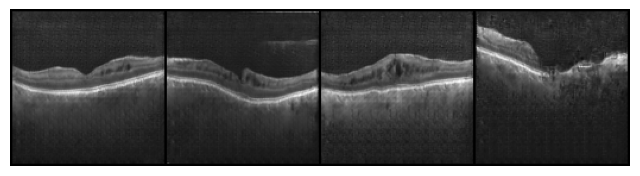

 98%|█████████▊| 2449/2500 [56:28:34<1:07:08, 78.98s/it]

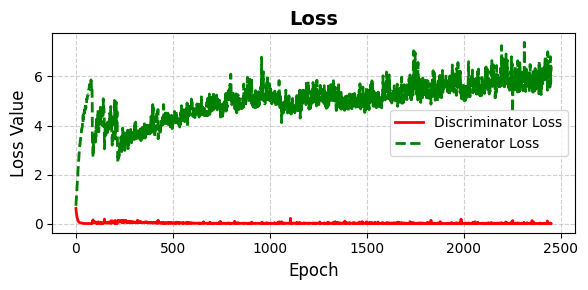

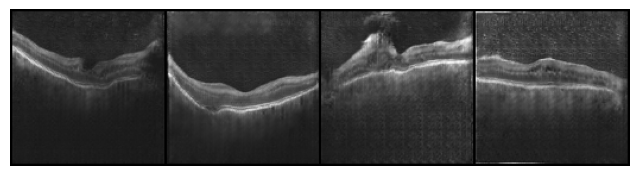

100%|█████████▉| 2499/2500 [57:36:30<01:28, 88.28s/it]  

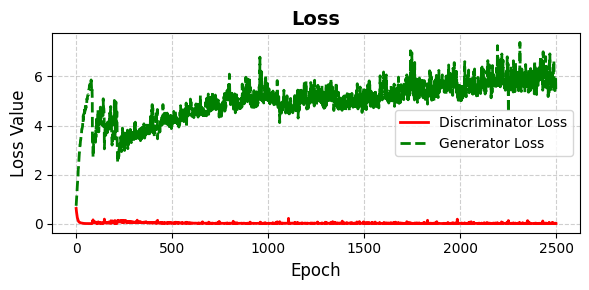

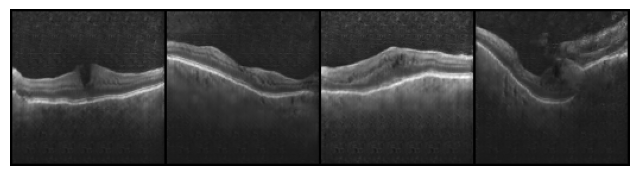

100%|██████████| 2500/2500 [57:37:49<00:00, 82.99s/it]


In [ ]:
latent_dim = 128  # Define latent space dimension

for epoch in tqdm(range(num_epochs)):
    total_loss_D = []
    total_loss_G = []
    for real_images, labels in (dataloader):
        # Get real images from the batch
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Generate fake images from noise
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_images = G(z).detach()  # Detach so G is not updated in this step

        # Get discriminator outputs
        pred_real = D(real_images)
        pred_fake = D(fake_images)

        # Create ground truth tensors
        valid = torch.ones_like(pred_real, device=device)
        fake = torch.zeros_like(pred_fake, device=device)

        # Compute discriminator loss
        loss_D_real = adversarial_loss(pred_real, valid)
        loss_D_fake = adversarial_loss(pred_fake, fake)
        loss_D = (loss_D_real + loss_D_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generator tries to fool the discriminator
        fake_images = G(z)  # DO NOT detach here!
        pred_fake = D(fake_images)
        valid = torch.ones_like(pred_fake, device=device)

        loss_G = adversarial_loss(pred_fake, valid)
        loss_G.backward()
        optimizer_G.step()
        total_loss_D += [loss_D.item()]
        total_loss_G += [loss_G.item()]
    loss_D_history+=[np.mean(total_loss_D)]
    loss_G_history+=[np.mean(total_loss_G)]
    # ---------------------
    #  Save Model Checkpoints (Every 50 epochs)
    # ---------------------
    if (epoch + 1) % 50 == 0 or epoch+1 == num_epochs:
        plot_history(loss_D_history, loss_G_history)
        with torch.no_grad():
            sample_noise = torch.randn(4, latent_dim, device=device)
            fake_images_sample = G(sample_noise).to('cpu')
            grid = torchvision.utils.make_grid(fake_images_sample, nrow=4, normalize=True, value_range=(-1, 1))

            # Fix color normalization issue
            img_np = normalize((grid.numpy().transpose(1, 2, 0) + 1) / 2)

        img_path = f"saved_images/epoch_{epoch+1:03d}.png"
        plt.imsave(img_path, img_np)

        plt.figure(figsize=(8, 4))
        plt.imshow(img_np)
        plt.axis("off")
        plt.show()
        torch.save(G.state_dict(), f"saved_models/generator_G_{epoch+1:03d}.pth")
        torch.save(D.state_dict(), f"saved_models/discriminator_D_{epoch+1:03d}.pth")


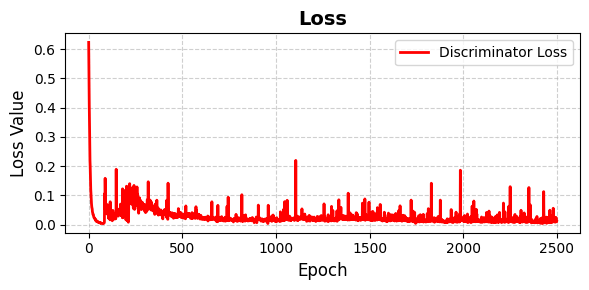

In [29]:
plt.figure(figsize=(6, 3))

plt.plot(loss_D_history, label="Discriminator Loss", color="red", linewidth=2, linestyle="-")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.title("Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

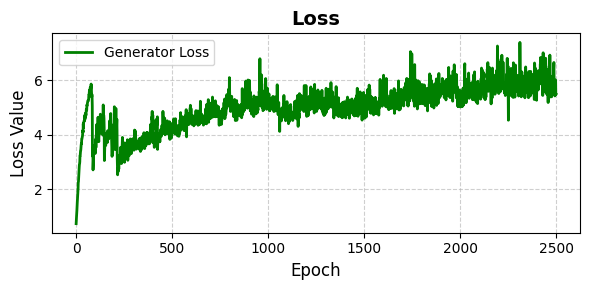

In [30]:
plt.figure(figsize=(6, 3))

plt.plot(loss_G_history, label="Generator Loss", color="green", linewidth=2, linestyle="-")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.title("Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

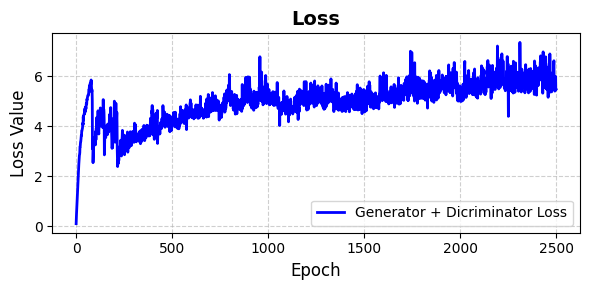

In [31]:
plt.figure(figsize=(6, 3))

plt.plot(np.subtract(loss_G_history,loss_D_history), label="Generator + Dicriminator Loss", color="blue", linewidth=2, linestyle="-")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.title("Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

In [37]:
import torch.onnx
dummy_input = torch.randn(1, 128) 
torch.onnx.export(G.to('cpu'), dummy_input, "model.onnx")
